In [60]:
#!pip install openai-clip

In [61]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from tqdm import tqdm
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datetime import datetime
from torchvision import models
#from transformers import CLIPProcessor, CLIPModel
import os
import csv
from peft import LoraConfig, get_peft_model
import json

import pandas as pd
import os
import random
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json

import transformers
from transformers import CLIPProcessor, CLIPModel
from multilingual_clip import pt_multilingual_clip # Note: add device parameter to forward manually
import open_clip


from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [63]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")
RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
WRITTEN_CAPTIONS_TESTING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TESTING_SET")
WRITTEN_CAPTIONS_VALIDATION_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_VALIDATION_SET")
FILE_FABRITIUS_ICONOGRAPHIES_JSON = PARENT + os.getenv("FILE_FABRITIUS_ICONOGRAPHIES_JSON")
EMBEDDINGS_FOLDER = PARENT + os.getenv("EMBEDDINGS_FOLDER")
MODELS_FOLDER = PARENT + os.getenv("MODELS_FOLDER")

##

def fixPath(path):
    return path.replace(".././", "../")

def get_image_path_from_recordID(dataset, recordID):
    """
    Given a recordID, return the local path for its image.
    """
    # Locate row in the downloaded DataFrame
    paths = dataset[
        dataset["recordID"] == recordID
    ]["low_res_filename"].values
    
    if len(paths) == 0:
        return None
    
    path = paths[0]
    # Merge: IMAGES_FOLDER + path[1:]
    merged_path = fixPath(os.path.join(IMAGES_FOLDER, path[1:]))
    return merged_path

In [64]:
safeFormat = lambda x : x.replace("/", "_").replace(":", "_").replace(" ", "_")
model_name = "ViT-L/14"
embedding_name = safeFormat(model_name) + "_embeddings.npy"

path_imagesEmbeddings = os.path.join(EMBEDDINGS_FOLDER, "images_" + embedding_name)
path_objectsEmbeddings = os.path.join(EMBEDDINGS_FOLDER, "objects_" + embedding_name)
path_othersEmbeddings = os.path.join(EMBEDDINGS_FOLDER, "others_" + embedding_name)

imagesEmbeddingExists = os.path.exists(path_imagesEmbeddings)
objectsEmbeddingExists = os.path.exists(path_objectsEmbeddings)
othersEmbeddingExists = os.path.exists(path_othersEmbeddings)

print(f"Images embedding exists: {imagesEmbeddingExists}")
print(f"Objects embedding exists: {objectsEmbeddingExists}")
print(f"Others embedding exists: {othersEmbeddingExists}")
embeddingExists = imagesEmbeddingExists and objectsEmbeddingExists and othersEmbeddingExists

Images embedding exists: True
Objects embedding exists: True
Others embedding exists: True


In [65]:
model_name = "openai/clip-vit-large-patch14"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name).to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
# Load the weights of the model
weights_path = os.path.join(MODELS_FOLDER, "2025-02-05 17_09_07_allFocus_5.pt")
# Load the weights of the model
model.load_state_dict(torch.load(weights_path))

C:\Users\victo\AppData\Local\Temp\ipykernel_27992\843811975.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))


<All keys matched successfully>

In [66]:
FULL_DATASET = pd.read_csv(FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED)
# Remove rows with corrupted images
FULL_DATASET = FULL_DATASET[FULL_DATASET["recordID"] != 11546]
FULL_DATASET = FULL_DATASET[FULL_DATASET["recordID"] != 5262]
FULL_DATASET

,recordLanguage,recordID,DatabaseId,LinkToVubis,objectWork.creatorDescription,objectWork.termClassification,objectWork.workID,objectWork.titleText,objectWork.objectWorkType,objectWork.measurementsDescription,...,objectWorkType_is_esquisse,objectWorkType_is_estampe,objectWorkType_is_grisaille,objectWorkType_is_photographie,objectWorkType_is_polyptyque,objectWorkType_is_retable,objectWorkType_is_sanguine,objectWorkType_is_triptyque,objectWorkType_is_ébauche,contains_desired_objectWorkType
0,fre,10002,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Henry de Groux,peinture (Dept. Art Moderne),12315,Portrait de Paul Verlaine,['tableau (toile)'],"[46.0, 38.0]",...,False,False,False,False,False,False,False,False,False,True
1,fre,10004,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Pierre Oyens,peinture (Dept. Art Moderne),3230,Les collègues,['tableau (toile)'],"[202.0, 177.0]",...,False,False,False,False,False,False,False,False,False,True
2,fre,10005,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Ferdinand Roybet,peinture (Dept. Art Moderne),6831,Portrait de femme,['tableau (panneau)'],"[81.0, 54.0]",...,False,False,False,False,False,False,False,False,False,True
3,fre,10016,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Henry de Groux,peinture (Dept. Art Moderne),12502,Christ aux outrages,['tableau (toile)'],"[173.0, 145.0]",...,False,False,False,False,False,False,False,False,False,True
4,fre,1003,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Alfred Stevens,peinture (Dept. Art Moderne),10714,Dame au chien,['tableau (panneau)'],"[26.9, 20.9]",...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,fre,9959,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,"Eugène Laermans, baron",oeuvre sur papier (Dept. Art Moderne),12312,"Femme, vue de dos",['dessin'],NaN,...,False,False,False,False,False,False,False,False,False,True
3008,fre,9960,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,"Eugène Laermans, baron",oeuvre sur papier (Dept. Art Moderne),12311,Sur le champ,['dessin'],NaN,...,False,False,False,False,False,False,False,False,False,True
3009,fre,9962,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Fernand Khnopff,oeuvre sur papier (Dept. Art Moderne),12264,Une aile bleue,['photographie'],NaN,...,False,False,False,True,False,False,False,False,False,True
3010,fre,999,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Constant Montald,peinture (Dept. Art Moderne),10613,La baignade,['détrempe'],"[525.0, 593.0]",...,False,False,False,False,False,False,False,False,False,True


In [67]:
# Load the iconographies (json file)
with open(FILE_FABRITIUS_ICONOGRAPHIES_JSON, "r", encoding="utf-8") as f:
    ICONOGRAPHIES = json.load(f)
len(ICONOGRAPHIES)

3010

In [68]:
class ComputeEmbeddingsDataset(Dataset):
    def __init__(self, dataframe, getImageFromRecordID):
        self.dataframe = dataframe
        self.getImageFromRecordID = getImageFromRecordID

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.dataframe.iloc[idx]

        recordID = row['recordID']
        caption = ""
        path = self.getImageFromRecordID(self.dataframe, recordID)

        path = path.replace("internet", "Internet")
        path = path.replace("Mod", "mod")
        path = path.replace("Old", "old")
        path = path.replace("Stefaan", "stefaan")
        path = path.replace("Art-Foto", "art-foto")
        image = Image.open(path)#.convert("RGB")

        return image, caption, recordID
    
def customBatchBuilder(samples):
    images, captions, recordIDs = zip(*samples)
    inputs = processor(text=captions, images=images, return_tensors="pt", padding=True, truncation=True)
    return inputs

if not embeddingExists:
    dataset = ComputeEmbeddingsDataset(FULL_DATASET, get_image_path_from_recordID)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=customBatchBuilder)
    print(len(dataset), len(dataloader))

In [69]:
def compute_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for sample in tqdm(dataloader):
            input_ids = sample['input_ids'].to(device)
            attention_mask = sample['attention_mask'].to(device)
            pixel_values = sample['pixel_values'].to(device)

            # Compute image embeddings
            image_features = model.get_image_features(pixel_values=pixel_values)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.flatten(1)

            embeddings.append(image_features)

    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()
    return embeddings

if not imagesEmbeddingExists:
    imagesEmbeddings = compute_embeddings(dataloader, model, device)
    # Save the embeddings
    np.save(path_imagesEmbeddings, imagesEmbeddings)
else:
    imagesEmbeddings = np.load(path_imagesEmbeddings)

imagesEmbeddings.shape

(3010, 768)

In [70]:
def getObjectsFreq(iconography):
    frequency = {}
    def visit(node):
        value = node["value"]
        children = node["children"]

        isGroup = value == "<group>"
        isRoot = value == "root"

        if not isGroup and not isRoot:
            if value not in frequency:
                frequency[value] = 0
            frequency[value] += 1

        for child in children:
            visit(child)

    for recordID in iconography:
        visit(iconography[recordID])

    # Divide by the number of records
    for key in frequency:
        frequency[key] = frequency[key] / len(iconography)

    return frequency

In [71]:
counts = getObjectsFreq(ICONOGRAPHIES)
print(len(counts), "unique objects")

# Order the objects by frequency
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

MIN_FREQ = -1.0 #0.05 # Minimum frequency to consider an object

counts_filtered = {k: v for k, v in counts.items() if v > MIN_FREQ}
print(len(counts_filtered), "objects with frequency >=", MIN_FREQ)

counts_filtered_objects = list(counts_filtered.keys())
print(counts_filtered_objects)

1328 unique objects
1328 objects with frequency >= -1.0
['figure', 'homme', 'barbe', 'groupe de figures', 'chapeau', 'femme', 'assis', 'pinceau', 'intérieur', 'atelier', 'chevalet', 'tableau', 'toile', 'table', 'livre', 'fleur', 'en buste', 'de profil', 'foule', 'soldat', 'casque', 'arme', 'lance', 'animal', 'cheval', 'chien', 'coiffure', 'couronne', 'épine', 'nu', 'en pied', 'vêtement', 'robe', 'noeud', 'à mi-corps', 'couvre-chef', 'parure', 'harnachement', 'habit', 'veste', 'jeune fille', 'enfant', 'fillette', 'coiffe', 'chapelet', 'gonfanon', 'église', 'chandelle', 'paysage', 'village', 'maison', 'arbre', 'représentation animalière', 'tissu', 'bijou', 'port', 'quai', 'bateau', 'bateau à voiles', 'pont', 'rocher', 'rive', 'nourrisson', 'religieux', 'prêtre', 'fourrure', 'chaussure', 'lit', 'baldaquin', 'cruche', 'plat', 'cuillère', 'architecture', 'pilastre', 'fenêtre', 'pavement', 'bâtiment', 'escalier', 'colonne', 'sculpture', 'statue', 'fond de paysage', 'ville', 'vieux', 'monnaie

In [72]:
arbitrary_objects = [
    "homme",
    "barbe",
    "chapeau",
    "femme",
    "table",
    "livre",
    "fleur",
    "cheval",
    "chien",
    "paysage",
    "maison",
    "arbre",
]
assert all([o in counts_filtered_objects for o in arbitrary_objects])

In [73]:
prompt_eng = {
    "homme": "Un homme",
    "barbe": "Une personne avec une barbe",
    "chapeau": "Une personne avec un chapeau",
    "femme": "Une femme",
    "table": "Une table",
    "livre": "Un livre",
    "fleur": "Une fleur",
    "cheval": "Un cheval",
    "chien": "Un chien",
    "paysage": "Un paysage",
    "maison": "Une maison",
    "arbre": "Un arbre",
}
prompt_eng

{'homme': 'Un homme',
 'barbe': 'Une personne avec une barbe',
 'chapeau': 'Une personne avec un chapeau',
 'femme': 'Une femme',
 'table': 'Une table',
 'livre': 'Un livre',
 'fleur': 'Une fleur',
 'cheval': 'Un cheval',
 'chien': 'Un chien',
 'paysage': 'Un paysage',
 'maison': 'Une maison',
 'arbre': 'Un arbre'}

In [74]:
objectsEmbeddingExists

True

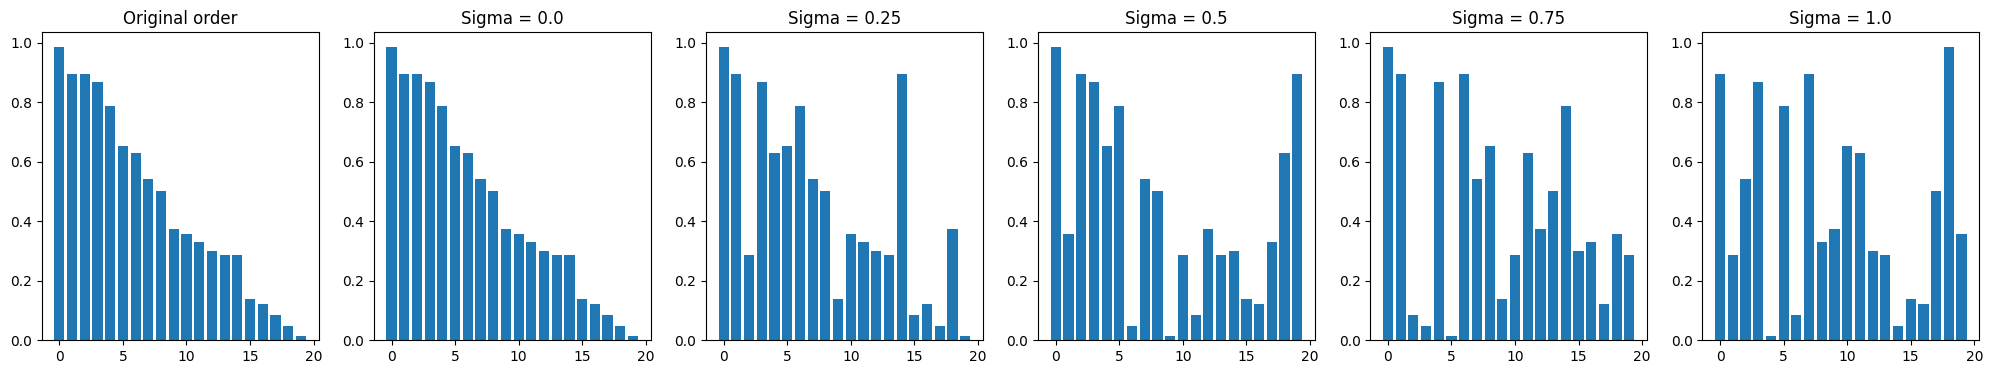

In [75]:
def select_N_questions(
    sigma,
    scores,
):
    indices = np.arange(len(scores))
    nb_swaps = int(sigma * len(scores))
    new_order = indices.copy()
    for _ in range(nb_swaps):
        i, j = np.random.choice(len(scores), 2, replace=False)
        new_order[i], new_order[j] = new_order[j], new_order[i]
    
    return new_order

N = 20
SCORES = np.random.rand(N)
# Order random_scores from highest to lowest
SCORES = np.sort(SCORES)[::-1]

SIGMAS = [0.0, 0.25, 0.50, 0.75, 1.0]

new_orders = []
for sigma in SIGMAS:
    new_order = select_N_questions(sigma, SCORES)
    new_orders.append(SCORES[new_order])

# Plot the new orders
fig, axs = plt.subplots(1, 1 + len(new_orders), figsize=(25, 4))

# Original order
axs[0].bar(np.arange(N), SCORES)
axs[0].set_title("Original order")

for i, sigma in enumerate(SIGMAS):
    axs[i + 1].bar(np.arange(N), new_orders[i])
    axs[i + 1].set_title(f"Sigma = {sigma}")

plt.show()

In [76]:
def compute_objects_embeddings(objects, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for object in tqdm(objects):
            inputs = processor(text=object, return_tensors="pt", padding=True, truncation=True)
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            # Compute text embeddings
            text_features = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            text_features = text_features.flatten(1)

            embeddings.append(text_features)

    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()

    return embeddings

if not objectsEmbeddingExists:
    objectsEmbeddings = compute_objects_embeddings(counts_filtered_objects, model, device)
    # Save the embeddings
    np.save(path_objectsEmbeddings, objectsEmbeddings)
else:
    objectsEmbeddings = np.load(path_objectsEmbeddings)

objectsEmbeddings.shape

(1328, 768)

In [77]:
LUMINOSITIES = [
    "Lumineux",
    "Sombre",
]

COLORS = [
    "Noir et blanc",
    "Couleurs vives",
    "Couleurs sombres",
    "Teinte rouge",
    "Teinte bleue",
    "Teinte verte",
]

TYPES = [
    "Portrait",
    "Paysage",
    "Sculpture",
]

OTHERS = LUMINOSITIES + COLORS + TYPES

In [78]:
if not othersEmbeddingExists:
    othersEmbedding = compute_objects_embeddings(OTHERS, model, device)
    # Save the embeddings
    np.save(path_othersEmbeddings, othersEmbedding)
else:
    othersEmbedding = np.load(path_othersEmbeddings)

othersEmbedding.shape

(11, 768)

In [79]:
objectsEmbeddings.shape, imagesEmbeddings.shape, othersEmbedding.shape

((1328, 768), (3010, 768), (11, 768))

In [80]:
cosine_similarity_matrix = cosine_similarity(imagesEmbeddings, objectsEmbeddings)
cosine_similarity_matrix.shape

(3010, 1328)

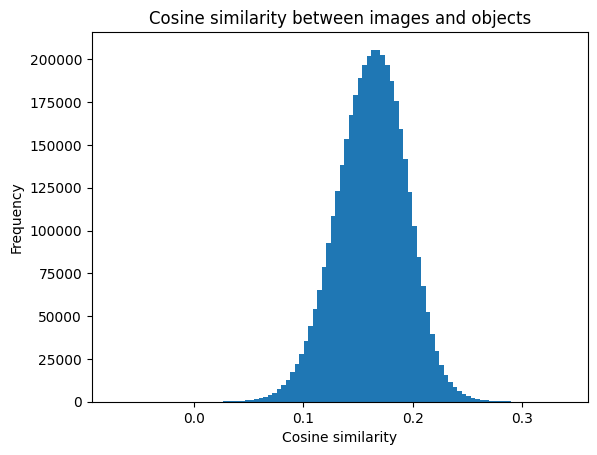

In [81]:
# Histogram of the cosine similarities
cosine_similarity_values = cosine_similarity_matrix.flatten()
plt.hist(cosine_similarity_values, bins=100)
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.title("Cosine similarity between images and objects")
plt.show()

In [82]:
from scipy.sparse import lil_matrix 
# Sparse matrix: recordID x object
object_presence_per_recordID = lil_matrix((len(arbitrary_objects), len(FULL_DATASET)), dtype=bool)
print(object_presence_per_recordID.shape)

recordIndex = 0
for _, row in FULL_DATASET.iterrows():
    recordID = row["recordID"]
    iconography = ICONOGRAPHIES[str(recordID)]

    def visit(node):
        value = node["value"]
        children = node["children"]

        isInFiltered = value in arbitrary_objects

        if isInFiltered:
            objectIndex = list(arbitrary_objects).index(value)
            object_presence_per_recordID[objectIndex, recordIndex] = True

        for child in children:
            visit(child)

    visit(iconography)
    recordIndex += 1

number_of_non_zero_elements = object_presence_per_recordID.count_nonzero()
print(number_of_non_zero_elements, "non-zero elements out of ", object_presence_per_recordID.shape[0] * object_presence_per_recordID.shape[1])

(12, 3010)
5603 non-zero elements out of  36120


In [83]:
def get_score(TP, FP, TN, FN):
    # Maximize the amount of true positives while minimizing the amount of false positives
    return TP - FP

In [84]:
accuracies = []
precisions = []
recalls = []
thresholds = []
stats = []
scores = []

for objectIndex, object in enumerate(arbitrary_objects):

    object_embedding = objectsEmbeddings[objectIndex].reshape(1, -1)

    # Get cosine similarities between the object and all images
    similarities = cosine_similarity_matrix[:, objectIndex].reshape(1, -1)

    # Find the threshold needed to get the correct predictions
    recordIDsWithObject = object_presence_per_recordID[objectIndex].nonzero()[1]
    recordIDsWithoutObject = np.setdiff1d(np.arange(len(FULL_DATASET)), recordIDsWithObject)

    similarities_with_object = similarities[0, recordIDsWithObject]
    similarities_without_object = similarities[0, recordIDsWithoutObject]
    
    # Find the threshold that separates the two distributions the best
    thresholds_cand = np.linspace(
        np.amin(similarities_without_object),
        np.amax(similarities_with_object),
        200
    )

    best_accuracy = -1
    best_recall = -1
    best_precision = -1
    best_score = -1
    best_stats = {
        "TP": 0,
        "FP": 0,
        "TN": 0,
        "FN": 0
    }
    best_score = -1

    best_threshold = None

    for threshold in thresholds_cand:
        TP, FP, TN, FN = 0, 0, 0, 0
        for similarity in similarities_with_object: # True positives
            if similarity > threshold:
                TP += 1
            else:
                FN += 1
        for similarity in similarities_without_object: # True negatives
            if similarity < threshold:
                TN += 1
            else:
                FP += 1

        if (TP + FN) == 0:
            recall = 0
        else:
            recall = TP / (TP + FN)
        
        if (TP + FP) == 0:
            precision = 0
        else:
            precision = TP / (TP + FP)

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        score = (precision + recall)/2

        if accuracy > best_accuracy: # Minimize the amount of false positives
            best_accuracy = accuracy
            best_precision = precision
            best_recall = recall
            best_threshold = threshold
            best_stats = {
                "TP": TP,
                "FP": FP,
                "TN": TN,
                "FN": FN
            }
            best_score = score
        
    accuracies.append(best_accuracy)
    precisions.append(best_precision)
    recalls.append(best_recall)
    thresholds.append(best_threshold)
    stats.append(best_stats)
    scores.append(best_score)

    print(object, best_accuracy, best_precision, best_stats["TP"], best_stats["FP"], best_stats["TN"], best_stats["FN"])

homme 0.513953488372093 0.5048183839881394 681 668 866 795
barbe 0.935548172757475 0.0 0 22 2816 172
chapeau 0.8780730897009966 0.0 0 18 2643 349
femme 0.6508305647840532 0.5773638968481375 403 295 1556 756
table 0.9415282392026578 0.07692307692307693 1 12 2833 164
livre 0.9395348837209302 0.05 1 19 2827 163
fleur 0.9431893687707641 0.4 2 3 2837 168
cheval 0.8973421926910299 0.0 0 71 2701 238
chien 0.8664451827242525 0.0 0 111 2608 291
paysage 0.7604651162790698 0.0 0 132 2289 589
maison 0.9119601328903655 0.14285714285714285 1 6 2744 259
arbre 0.8096345514950166 0.0 0 3 2437 570


In [85]:
# Sample 10 random recordIDs from the dataset
def plotCandidates(candidates, query, answers=None):
    if answers is None:
        answers = {
            "N/A": [False] * len(candidates)
        }

    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    for i, ax in enumerate(axs.flat):
        recordID = candidates.iloc[i]["recordID"]
        path = get_image_path_from_recordID(candidates, recordID)
        image = Image.open(path)
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        # Add a red border if the answer is NO
        answerText = []
        for key in answers:
            answerText.append(f"{key}: {'YES' if answers[key][i] else 'NO'}")
        ax.set_title("\n".join(answerText))
    plt.suptitle(f"Query: {query}")
    plt.show()

homme


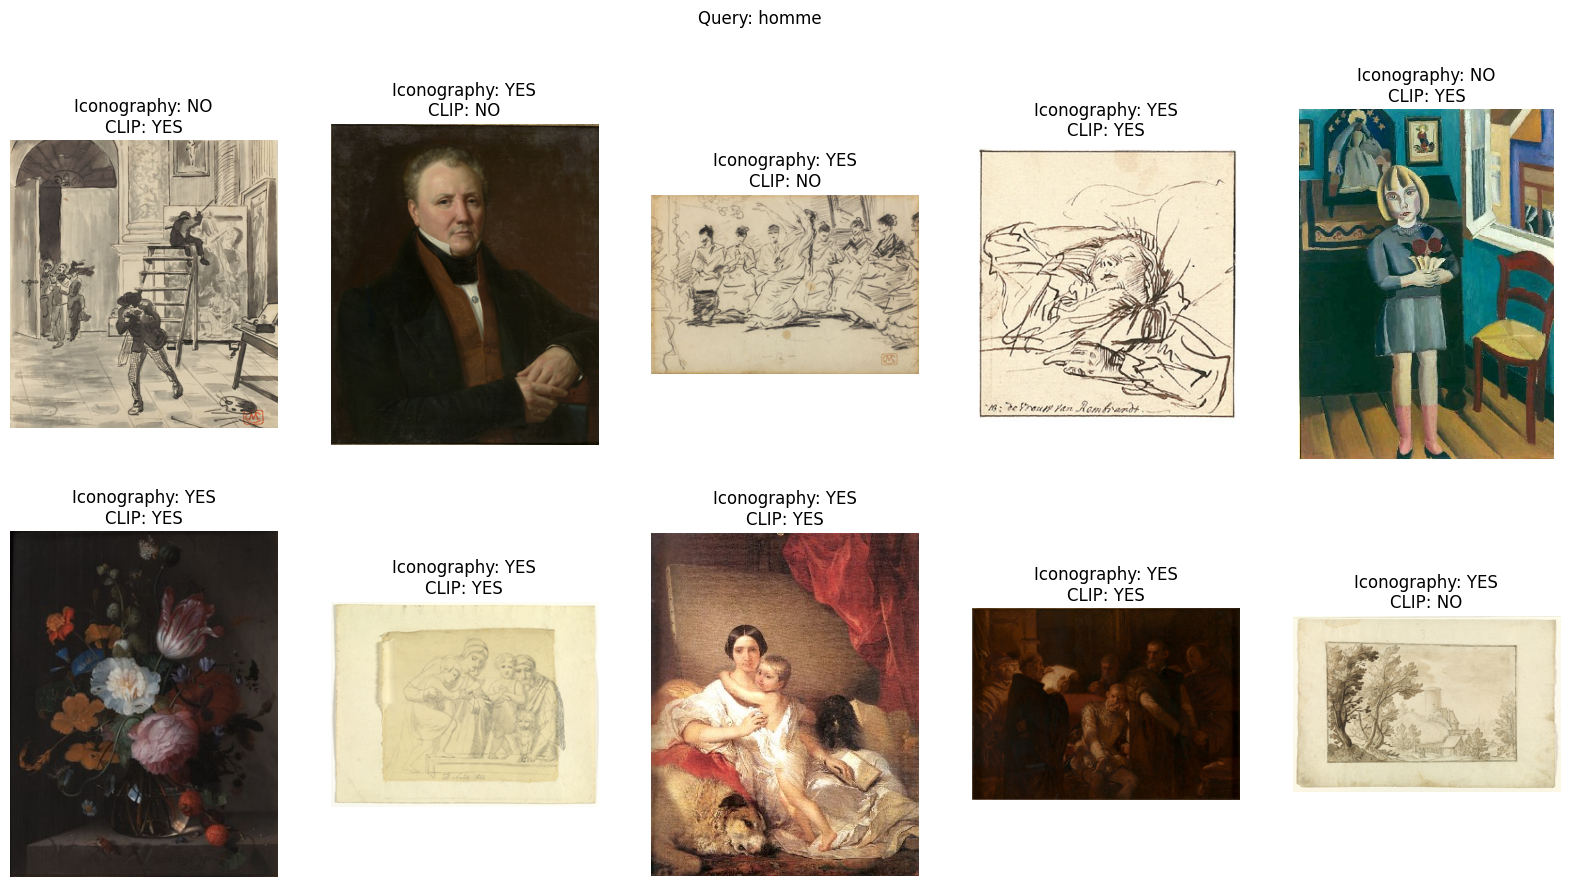

In [86]:
def get_answers(candidates, objectIndex, threshold):
    # Get embeddings for each candidate
    candidatesIndexes = candidates.index
    candidate_embeddings = imagesEmbeddings[candidatesIndexes]

    # Get logits for each candidate
    similarities = cosine_similarity(candidate_embeddings, objectsEmbeddings[objectIndex].reshape(1, -1))

    # Threshold
    answers = similarities > threshold
    return answers

def get_answers_ico(candidates, term):
    # Get the flattened iconography
    candidatesIndexes = candidates.index
    isObjectInIconography = object_presence_per_recordID[:, candidatesIndexes].toarray().T

    # Get the index of the object
    objectIndex = arbitrary_objects.index(term)

    # Get the answers
    answers = isObjectInIconography[:, objectIndex]

    return answers


candidates = FULL_DATASET.sample(10)

index = 0
objectName = arbitrary_objects[index]
print(objectName)

answers_ico = get_answers_ico(candidates, objectName)
answers_clip = get_answers(candidates, index, thresholds[index])
plotCandidates(candidates, objectName, {
    "Iconography": answers_ico,
    "CLIP": answers_clip
})

In [87]:
loaded_imagesEmbeddings = np.load(path_imagesEmbeddings)
print(np.mean(loaded_imagesEmbeddings), np.std(loaded_imagesEmbeddings))

0.0009384602 0.036072187


In [88]:
def get_query_embedding(query):
    model.eval()

    inputs = processor(text=query, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Compute text embeddings
    text_features = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
    #text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.flatten(1)

    return text_features.cpu().detach().numpy()

def get_queries_embedding(queries):
    weights = [query['weight'] for query in queries]
    values = [query['value'] for query in queries]

    embeddings = [get_query_embedding(query) for query in values] # List of numpy arrays
    embeddings = np.array(embeddings) # Convert to numpy array

    # Multiply each embedding by its weight
    for i in range(len(embeddings)):
        embeddings[i] *= weights[i]
    
    # Sum all the embeddings
    embeddings = np.sum(embeddings, axis=0)

    # Normalize
    embeddings /= np.linalg.norm(embeddings)

    return embeddings

def getRecordID(index):
    return FULL_DATASET.iloc[index]["recordID"]

def get_k_closest_images_from_queries(queries, k):
    queries_embedding = get_queries_embedding(queries)
    sims = cosine_similarity(queries_embedding, loaded_imagesEmbeddings).squeeze()
    indices = np.argsort(sims)[::-1]
    
    # Get the best k index of the images
    best_indices = indices[:k]

    # Get the recordID of the best images
    best_entries = [getRecordID(index) for index in best_indices]

    return best_entries

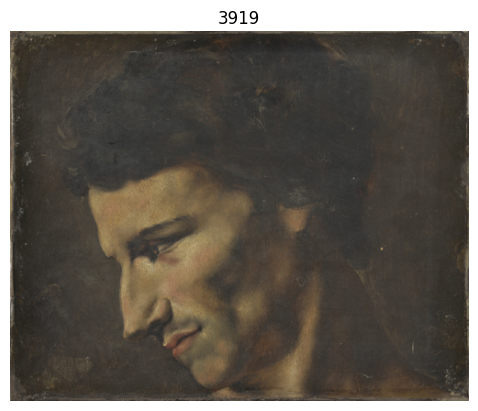

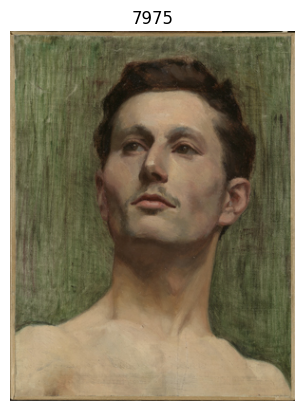

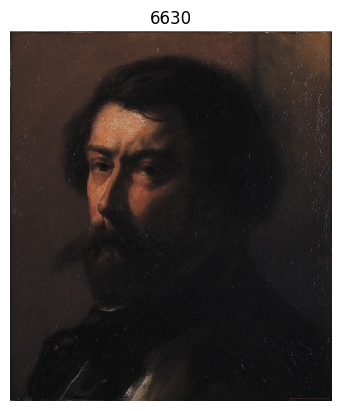

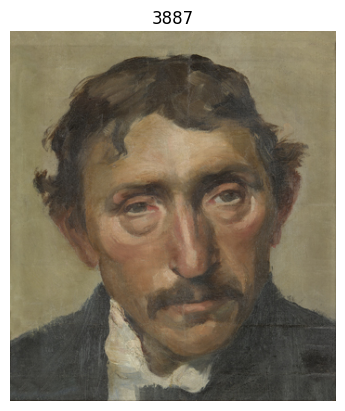

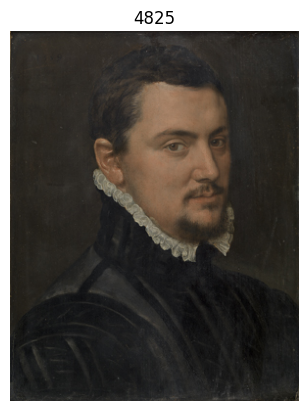

In [89]:
queries = [
    {
        "id": "keyword__Un homme",
        "type": "keyword",
        "value": "Portrait d'un homme",
        "weight": 1
    },
]

k = 5
best_entries = get_k_closest_images_from_queries(queries, k)
best_entries = [int(recordID) for recordID in best_entries]

for recordID in best_entries:
    # Plot
    path = get_image_path_from_recordID(FULL_DATASET, recordID)
    image = Image.open(path)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.title(recordID)
    plt.show()

In [91]:
def test():
    recordIDs = get_k_closest_images_from_queries([
        {
            "id": "keyword__Un homme",
            "type": "keyword",
            "value": "Portrait d'un homme",
            "weight": 1
        }
    ], 5)
    recordIDs = [int(recordID) for recordID in best_entries]
    print(recordIDs, [3919, 7975, 6630, 3887, 4825])
    assert recordIDs == [3919, 7975, 6630, 3887, 4825], recordIDs

test()

[3919, 7975, 6630, 3887, 4825] [3919, 7975, 6630, 3887, 4825]
